In [1]:
import numpy as np
import arepo
import matplotlib.pyplot as plt

In [2]:
basepath = '/n/holylfs05/LABS/hernquist_lab/Users/abeane/GSEgas'

In [3]:
sn = arepo.Snapshot(basepath + '/FIRE/m12i_res7100/output/', 172, combineFiles=True)

In [4]:
def compute_T(sn):
    u = sn.part0.InternalEnergy
    xe = sn.part0.ElectronAbundance
    
    gamma=5/3
    
    XH = 0.76
    mp = 1.672621911E-24
    mu = 4 * mp / (1 + 3*XH + 4*XH*xe)
    
    kB = 1.381E-16
    
    T = (gamma - 1.) * (u/kB) * 1E10 * mu
    return T

def compute_n(sn):
    rho = np.copy(sn.part0.Density)
    xe  = sn.part0.ElectronAbundance
    # print(rho[rho>0])
    
    #convert rho to cgs
    UnitMass   = 1.989e43
    UnitLength = 3.085678e21
    rho *= UnitMass/UnitLength**3
    # print(UnitMass/UnitLength**3)
    
    XH = 0.76
    mp = 1.672621911E-24
    mu = 4 * mp / (1 + 3*XH + 4*XH*xe)
    
    # print(np.median(mu))
    # print(np.where(np.isnan(rho[rho>0]))[0])
    # print(rho[:10])
    
    n = rho / mu
    
    return n

In [5]:
def Jeans(sn):
    gamma = 5./3.
    
    # P = sn.part0.Pressure
    P = (gamma-1)*sn.part0.rho * sn.part0.u
    rho = sn.part0.rho
    
    cssq = gamma * P / rho
    G = 43018.7
    
    LJ = np.sqrt(np.pi * cssq / (G * rho))
    
    # cell_volume = sn.part0.mass.value / sn.part0.rho.value
    # cell_size = (3/(4*np.pi) * cell_volume)**(1./3.)
    cell_size = sn.part0.SmoothingLength
    
    return LJ, cell_size

In [29]:
n = compute_n(sn)
T = compute_T(sn)

In [30]:
print(np.max(np.log10(n)))

3.1198332


In [23]:
LJ, size = Jeans(sn)

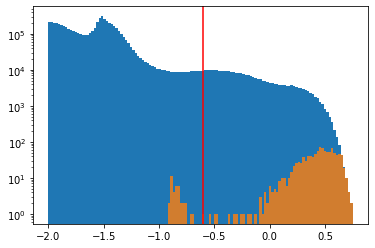

In [32]:
key = sn.part0.sfr > 0

plt.hist(np.log10(size/LJ), bins=np.linspace(-2, 0.75, 128));
plt.hist(np.log10(size[key]/LJ[key]), bins=np.linspace(-2, 0.75, 128), alpha=0.8);
plt.yscale('log')
plt.axvline(np.log10(0.25), c='r')

In [42]:
UnitMass_in_g = 1.989e+43
UnitVelocity_in_cm_per_s = 100000
UnitTime_in_s = 3.08568e+16
SOLAR_MASS = 1.989e33
SEC_PER_YEAR = 3.15576e7

In [41]:
np.argmax(sn.part0.rho)
pos_nmax = sn.part0.pos[np.argmax(sn.part0.rho)]
rdiff = np.linalg.norm(sn.part0.pos - pos_nmax, axis=1)
key = rdiff < 0.1
print(len(np.where(key)[0]))

print(np.sum(sn.part0.sfr[key]))
print(np.sum(sn.part0.mass[key])*1E10)


171
0.22983384
892303.2146412879


In [43]:
Mg = np.sum(sn.part0.mass[key])
sfr = np.sum(sn.part0.sfr[key])
sfr_cu = sfr / ((UnitMass_in_g / SOLAR_MASS) / (UnitTime_in_s / SEC_PER_YEAR))

print(sfr)
print(Mg*1E10)
print(Mg/sfr_cu)

0.22983384
892303.2146412879
0.003970558173716877


In [44]:
rdiff4 = np.linalg.norm(sn.part4.pos - pos_nmax, axis=1)
key4 = rdiff4 < 0.1

In [50]:
print(np.sum(sn.part4.mass[key4])/Mg)

0.17268185


### comparing across snapshots

In [8]:
sn172 = arepo.Snapshot(basepath + '/FIRE/m12i_res7100/output/', 172, combineFiles=True)

In [9]:
sn214 = arepo.Snapshot(basepath + '/FIRE/m12i_res7100/output/', 214, combineFiles=True)

In [25]:
def get_pos_mass(sn):
    pos = []
    vel = []
    mass = []
    
    for i in [0, 1, 2, 3, 4]:
        if sn.NumPart_Total[i] > 0:
            part = getattr(sn, 'part'+str(i))
            pos.append(part.pos)
            vel.append(part.vel)
            if sn.MassTable[i] > 0:
                mass.append(np.full(sn.NumPart_Total[i], sn.MassTable[i]))
            else:
                mass.append(part.mass)
    
    pos = np.concatenate(pos)
    vel = np.concatenate(vel)
    mass = np.concatenate(mass)
    
    return pos, vel, mass
            

In [26]:
pos172, vel172, mass172 = get_pos_mass(sn172)
pos214, vel214, mass214 = get_pos_mass(sn214)

In [27]:
Lz172 = mass172*np.cross(pos172, vel172)[:,2]
print(np.sum(Lz172))

-20027739589.600594


In [28]:
Lz214 = mass214*np.cross(pos214, vel214)[:,2]
print(np.sum(Lz214))

-12474245400.026144
